In [1]:
import pandas as pd
import os
import cv2
import numpy as np

from sklearn.svm import SVC

from datetime import datetime
import time

from sklearn.metrics import make_scorer, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [7]:
X_train = np.loadtxt("GLCM_CIR/GLCM_CIR_noaug/X_train_CIR_noaug.csv", delimiter=",")
y_train = np.loadtxt('GLCM_CIR/GLCM_CIR_noaug/y_train_CIR_noaug.csv', delimiter=",")
X_test = np.loadtxt('GLCM_CIR/GLCM_CIR_noaug/X_test_CIR_noaug.csv', delimiter=",")
y_test = np.loadtxt('GLCM_CIR/GLCM_CIR_noaug/y_test_CIR_noaug.csv', delimiter=",")

In [8]:
scorer = make_scorer(f1_score, pos_label=1)

In [9]:
import time
s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 0.5],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.1321572871572872
44.89948225021362


In [10]:
best_params = grid_search.best_params_

In [11]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [12]:
best_svc_clf.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma=0.1, probability=True, random_state=42)

Max Sensitivity at Specificity >= 0.94: 0.10


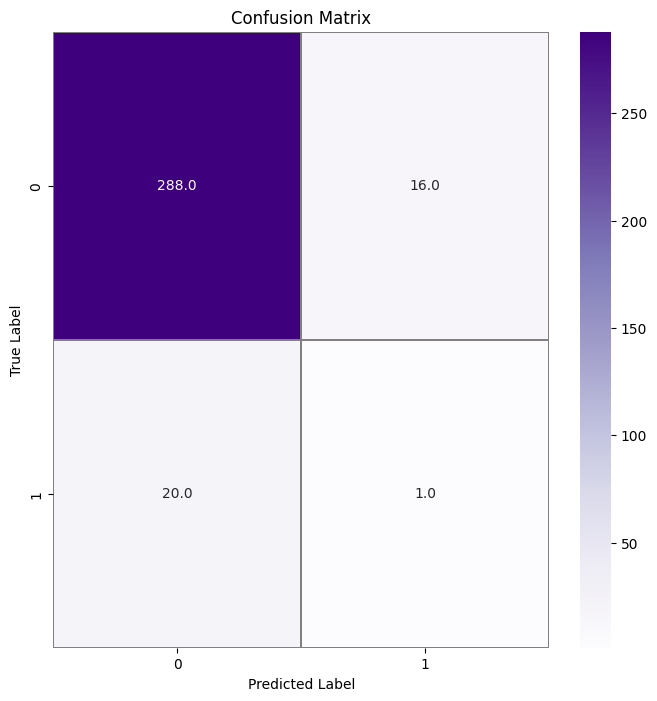

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       304
         1.0       0.06      0.05      0.05        21

    accuracy                           0.89       325
   macro avg       0.50      0.50      0.50       325
weighted avg       0.88      0.89      0.88       325

           Model Name  Max Sensitivity at Specificity 0.94   AUC   
0  CIR-SVC-noaug-poly                                  0.1  0.55  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV   
0                     0.05      0.89         0.05         0.95  0.06  0.94  \

   PLR   NLR  
0  0.9  1.01  


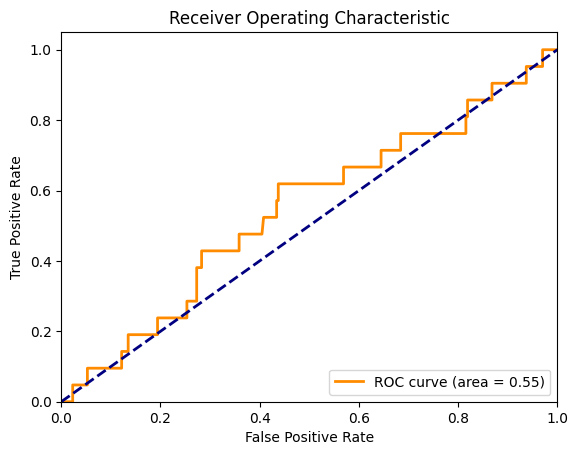

In [13]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-noaug-poly')

In [14]:
import time
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

s = time.time()
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000, 10000],
    'class_weight': [None, 'balanced']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LinearSVC(), param_grid=param_grid, cv=10, scoring=scorer)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
e = time.time()
print(e-s)

Best Parameters: {'C': 1000, 'class_weight': 'balanced'}
Best Score: 0.12076923076923077
8.19005298614502


In [15]:
best_params = grid_search.best_params_

In [16]:
best_svc_clf = SVC(**best_params, probability=True, random_state=42)

In [17]:
best_svc_clf.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced', probability=True, random_state=42)

Max Sensitivity at Specificity >= 0.94: 0.05


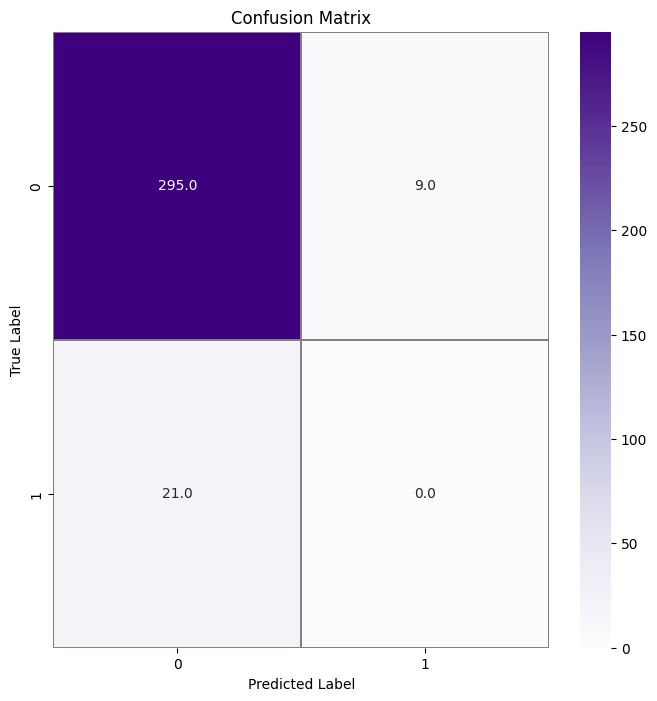

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       304
         1.0       0.00      0.00      0.00        21

    accuracy                           0.91       325
   macro avg       0.47      0.49      0.48       325
weighted avg       0.87      0.91      0.89       325

             Model Name  Max Sensitivity at Specificity 0.94   AUC   
0  CIR-SVC-noaug-linear                                 0.05  0.52  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV   
0                      0.0      0.91          0.0         0.97  0.0  0.93  \

   PLR   NLR  
0  0.0  1.03  


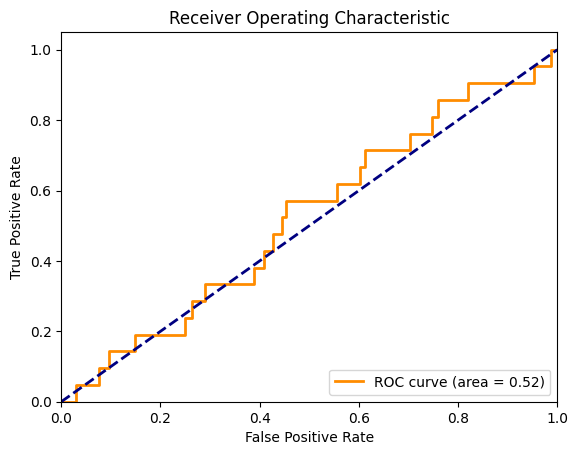

In [18]:
get_model_metrics(test_data=[X_test,y_test], model=best_svc_clf, model_name='CIR-SVC-noaug-linear')